# End-to-End Deep Learning
_____________________________________________

## 1. Introduction
_______________________

In this notebook we will go through the entire lifecycle of a deep learning model from data to deployment. We will train, analyze, and deploy a classification model using the Tensorflow Keras library. After the model has been trained, we will use Descartes Labs APIs to distribute our model across our points of interest.

In this demo we will use the following Descartes Labs interfaces:
- Downloading images from `Catalog` with `Scenes` [ML: Add links for the module docs?]
- Uploading and downloading models with `Storage`
- Creating, uploading, and downloading `Vectors`
- Distributed computing with `Tasks`

The dataset we will be using for this tutorial is the [Brazilian Coffee Scenes Dataset](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/), a freely available geospatial dataset of 64x64 pixel tiles with or without the presence of coffee plants. In total there are over 3000 tiles, half contain coffee.

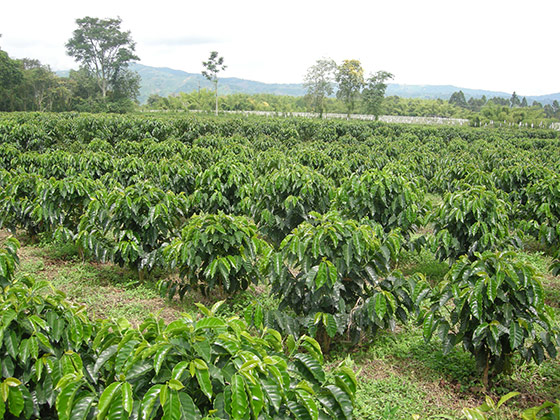

## 2. Data
____________________

Let's download and investigate the dataset. We can use Python libraries to download and unzip the files.

In [1]:
def download_and_unzip_data(url):
    import requests, zipfile, io, os
    r = requests.get(url, stream=True)
    if r.ok:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()

In [4]:
url = 'http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip'
download_and_unzip_data(url)

The images are found in five different folders for cross-validation. For this analysis we will treat the first four folds as a training set. The last fold will be held out for a validation set, which will be used to test our out of sample accuracy. Below we clean up and restructure the data. [ML: I googled and found out that 'fold' is a machine learning term, but I initially thought this was a typo for 'folder'. You may want to add a line explaining that the 'folders' designate the different 'folds' of the model or something]

In [16]:
def clean_data(folder_name):
    import os
    # [ML: You could also use os.listdir() to list all the files in the folder and then loop
    # through the results that pass str.endswith('.txt') instead of relying on the arbitrary range.
    # That approach might make it more clear to users what you're doing.]
    for i in range(1, 6):
        file_name = os.path.join(folder_name, 'fold' + str(i) + '.txt')
        with open(file_name) as f:
            img_list = f.readlines()

        for img in img_list:
            data = img.split('.')
            label = data[0]
            img_name = '.'.join(data[1:]).strip() + '.jpg'

            fold_dir = os.path.join(folder_name, 'fold' + str(i))
            if i < 5:
                label_dir = os.path.join(folder_name, 'train', label)
            else:
                label_dir = os.path.join(folder_name, 'val', label)

            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            os.rename(os.path.join(fold_dir, img_name), os.path.join(label_dir, img_name))

        os.remove(file_name)
        thumbnail = os.path.join(fold_dir, 'Thumbs.db')
        if os.path.exists(thumbnail):
            os.remove(thumbnail)
        os.rmdir(fold_dir)

In [17]:
folder_name = 'brazilian_coffee_scenes'
clean_data(folder_name)

[ML: Add a note stating that clean_data's purpose is to reorganize the data into the structure needed for training the model]
Now we have four folders, one for each combination of training mode and label. 
    
    brazilian_coffee_scenes
        ├── train
        |   ├── coffee
        |   └── noncoffee 
        └── val
            ├── coffee
            └── noncoffee
            
Let's visualize what our images look like.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
%matplotlib inline

def plt_sample_scenes(dir_path, ax, start, end):
    i = start
    for _, _, f in os.walk(dir_path):
        for file in f:
            ax[i].imshow(mpimg.imread(os.path.join(dir_path, file)))
            ax[i].set_yticks([])
            ax[i].set_xticks([])
            i += 1
            if i > end:
                break
    ax[start].set_ylabel(dir_path.split('/')[-1].split('_')[0])

ValueError: Only know how to handle extensions: [u'png']; with Pillow installed matplotlib can handle more images

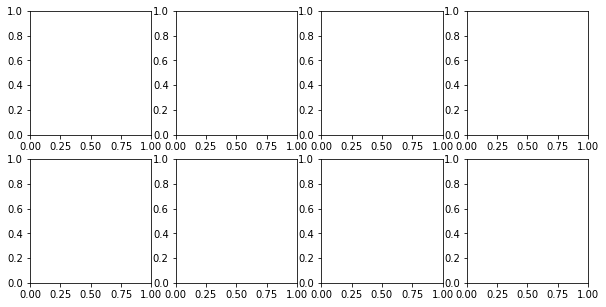

In [10]:
# [ML: this triggered an error for me
# "ValueError: Only know how to handle extensions: [u'png']; with Pillow installed matplotlib can handle more images"
# Add a note at the beginning of the tutorial outlining what dependencies are needed for this.]
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
ax = np.ravel(ax)
coffee_dir  = os.path.join(folder_name, 'train', 'coffee')
noncoffee_dir = os.path.join(folder_name, 'train', 'noncoffee')
plt_sample_scenes(coffee_dir, ax, 0, 3)
plt_sample_scenes(noncoffee_dir, ax, 4, 7)

Above are some example images of coffee and noncoffee tiles. According to the data description, the coffee tiles have at least 85% or more of their pixels containing coffee. The tiles also use spectral bands outside the visual. Spectral data is one major difference in remote sensing compared to traditional deep learning methods. In this case, the near-infrared (NIR) band will help us classify different types of vegetation.

## 3. Model
____________________

The model that we will be using is a ResNet classifier pretrained on ImageNet. Pretrained models are useful because they perform well even with limited training data. We will modify the model to support our particular use case. The implementation of ResNet50 found in [keras.applications](https://keras.io/applications/) will be our base model. We want to start with ImageNet weights, but we don't want to include the last set of fully connected layers [ML: will the user know what 'fully-connected layers' are? Should we add an explanation?] . That's because our data has only 2 classes instead of the 1000 that ImageNet has. Below we load the base model with parameters we specified. We will use the the Keras implementation that is a part of Tensorflow. Before you continue, make sure to update to the latest version of [TensorFlow](https://www.tensorflow.org/) so make sure to upgrade to version `1.14`. 

In [2]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [3]:
def load_base_model(image_shape=(64, 64, 3)):
    from tensorflow.keras.applications.resnet50 import ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
    return base_model

In [4]:
base_model = load_base_model()

/usr/local/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 24s 0us/step


Now we need to add an output layer that will take the activations from the convolutional layers and turn them into predictions. The straightforward approach is to flatten the output and feed the resulting vector into a few fully-connected layers. The sigmoid activation will produce an output between 0 and 1. During training, the result will be pushed closer to 0 if the image is coffee and closer 1 if the image is not coffee. During inference a threshold will be chosen to binarize the predictions.

In [5]:
def make_binary_classifier(base_model):
    from tensorflow.keras.layers import Flatten, Dense, Dropout
    from tensorflow.keras.models import Sequential
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [6]:
model = make_binary_classifier(base_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Our model architecture is completed. Before we can train our model, we need to compile it with a loss function and optimizer. A reasonable choice of optimizer is [Adam](https://arxiv.org/abs/1412.6980v8) - it performs well in most real-world senarios. We will use [binary crossentropy](https://keras.io/losses/) as a loss as it is suitable for binary classification problems.

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We have written these all as functions to be easier to use during training, which we will discuss in the next section. Let's package the model construction into one function which will load and produce a model ready for training.

In [8]:
def make_model():
    model = load_base_model()
    model = make_binary_classifier(model)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = make_model()

In [10]:
model.layers

## 4. Training
______________________

We are now ready to train our model. Deep learning models are typically trained using stochastic gradient descent over batches of data. Keras has a built-in generator,  `ImageDataGenerator`, that will feed our model data in batches. As we create instances of the generator, we can set common data augmentation functions. Data augmentation is important because it helps the model to generalize even with limited training data. The validation data is not augmented. The function `preprocess_input` from the ResNet model is important because it standarizes the data into the format that the model expects.

In [11]:
def setup_generator(train_dir, val_dir, image_shape, batch_size=32):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications.resnet50 import preprocess_input

    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=preprocess_input
    )
    
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        class_mode='binary',
        target_size=image_shape, 
        batch_size=batch_size
    )
    
    val_gen = val_datagen.flow_from_directory(
        val_dir,
        class_mode='binary',
        target_size=image_shape, 
        batch_size=batch_size
    )
    
    return train_gen, val_gen

Each `ImageDataGenerator` has methods which allow it to easily access data. We will use the `flow_from_directory` method because our data is already nicely partioned. Let's check how many images our generator should see.

In [18]:
train_dir = os.path.join(folder_name, 'train')
val_dir = os.path.join(folder_name, 'val')
train_gen, val_gen = setup_generator(train_dir, val_dir, image_shape=(64, 64))

Found 2400 images belonging to 2 classes.
Found 476 images belonging to 2 classes.


Now that our data generators are setup, it's time to train our model. Because this step can take a long time on CPU, you may **skip to the next step** to train the model on a GPU in Tasks.

In [17]:
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=3)

Epoch 1/3
75/75 [==============================] - 131s 2s/step - loss: 0.6343 - acc: 0.8054 - val_loss: 92.1506 - val_acc: 0.6954
Epoch 2/3
75/75 [==============================] - 113s 2s/step - loss: 0.6664 - acc: 0.8058 - val_loss: 169.5143 - val_acc: 0.5378
Epoch 3/3
75/75 [==============================] - 125s 2s/step - loss: 0.4455 - acc: 0.8471 - val_loss: 1.2462 - val_acc: 0.7311


We can plot the results.

In [18]:
def plot_loss(history):
    plt.figure()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

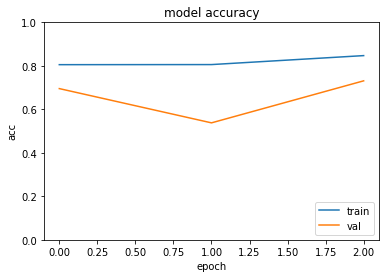

In [19]:
plot_loss(history.history)

Although we didn't train for that many epochs, we can see the accuracy increase over time.

## 5. Training on Tasks
_____________________

Training on a CPU is prohibitively time consuming for training deep learning models. Tasks [ML: Add link/explanation] can help by accelerating our training process with GPUs [ML: and parallelizing it across many workers? or does that not apply here?]. Let's put together a training function from what we've done in the previous sections. Because a task function is self-contained, it must include a way to download the data, setup the generators, and load the model.

In [19]:
def train_classifier(epochs):
    from tensorflow.keras.callbacks import ModelCheckpoint
    import descarteslabs as dl
    import os, json
    
    folder_name = 'brazilian_coffee_scenes'
    train_dir = os.path.join(folder_name, 'train')
    val_dir = os.path.join(folder_name, 'val')
    url = 'http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip'
    image_shape = (64, 64, 3)
    
    print('Downloading and cleaning data!')
    download_data(url)
    clean_data(folder_name)
    
    print('Loading model and generators')
    model = make_model()
    train_gen, val_gen = setup_generator(train_dir, val_dir, image_shape=image_shape[0:2])
    
    print('Training model')
    model_name = 'coffee_demo.hdf5'
    check = ModelCheckpoint(model_name, save_best_only=True)    
    history = model.fit_generator(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[check])
    log = {}
    for key in history.history:
        log[key] = [float(v) for v in history.history[key]]
    
    print('Upload model to Storage')
    storage = dl.Storage()
    storage.set_file(model_name.split('.')[0], model_name)
    storage.set('coffee_history', json.dumps(log))

We also use the `Storage` API [ML: add link] within `Tasks` to store our trained model output so we can access it later for analysis. Now that we have a training function, we can create a Task group and submit the job. Make sure the specify a GPU when the Task group is created [ML: How do you do this?]. As before we must use the image with the matching Python version.

In [20]:
# Uncomment the image version that matches the `sys.executable` version of the python kernel you are running locally.
import sys
sys.executable

'/usr/local/opt/python/bin/python3.7'

In [21]:
# Python 3.5
# gpu_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.5-gpu/default:v2019.08.08-8-g0948e514'
# Python 3.6
# gpu_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.6/default:v2019.08.08-8-g0948e514'
# Python 3.7
gpu_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7/default:v2019.08.08-8-g0948e514'

In [22]:
import descarteslabs as dl
tasks = dl.Tasks()
async_train = tasks.create_function(
    f=train_classifier,
    name='coffee-training-demo',
    image=gpu_image,
    maximum_concurrency=1,
    memory='4Gi',
    gpus=1
)

ModuleNotFoundError: No module named 'descarteslabs'

Now let's submit a training job.

In [22]:
t = async_train(epochs=20)

We can get a log to check the status of the task.

In [24]:
# Uncomment the next line to see the full log output. It can be very long.
# t.log

Let's retrieve the history of the training from Storage and plot the training epochs.

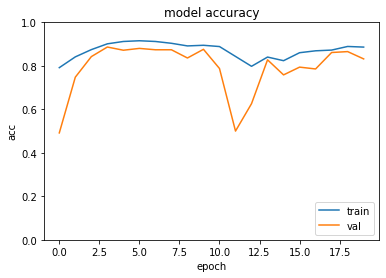

In [24]:
import json
storage = dl.Storage()
history = storage.get('coffee_history')
h = json.loads(history.decode('utf-8'))
plot_loss(h)

After 20 epochs the model starts overfitting [ML: How can you tell this?], but thankfully we have setup a Keras checkpoint callback which only saves the model that performed the best. The highest validation accuracy should be around 90%.

In [25]:
max(h['val_acc'])

0.8865545988082886

## 6. Predictions
________________

To look at some predictions made by our model, we can load it from the saved version from before by downloading the model from Storage. [ML: I'm confused - why load the saved version and then download the model again from storage? are you downloading the results from storage?]

In [26]:
import descarteslabs as dl
storage = dl.Storage()

In [27]:
def load_model_from_storage(model_name):
    from tensorflow.keras.models import load_model
    import descarteslabs as dl
    storage = dl.Storage()
    storage.get_file(model_name, model_name + '.h5')
    model = load_model(model_name + '.h5')
    return model

In [49]:
model = load_model_from_storage('coffee_demo')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 24,636,545
Trainable params: 24,583,425
Non-trainable params: 53,120
_________________________________________________________________


Here we load an example image and preprocess it using the preprocessing function we used during training.

In [30]:
import matplotlib.pyplot as plt

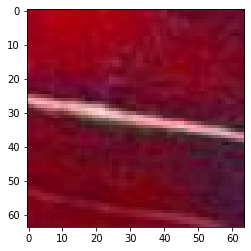

In [31]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
# [ML: Again here you could do os.listdir('brazilian_coffee_scenes/val/coffee') and just pick 
# the first image in case file names change on the third party site in the future] 
test_name = os.path.join('brazilian_coffee_scenes', 'val', 'coffee', 'arceburgo.T4352.B4416.L4032.R4096.jpg')
img = image.load_img(test_name)
img = image.img_to_array(img)
plt.imshow(img.astype('uint8'))
img = preprocess_input(img)

This tile is in the test set and is known to have coffee. What does the model think? Prediction is as simple as calling the `model.predict` method.

In [32]:
label_schema = {0: 'coffee', 1: 'notcoffee'}
pred = model.predict(img[None,:])
label_schema[int(pred[0] > 0.5)]

'coffee'

With any luck, the model will have predicted the correct result. If the model isn't performing well, several additional epochs of training might be needed to improve the model to the level of accuracy required. Some improvements could be changing hyperparmeters, training time, or model architecture.

## 7. Deploying
______________

Once we have a trained model we are happy with, it's time to deploy it. For example, we might want to deploy our newly trained model over regions of Brazil in order to detect newly planted fields. For large-scale inference, we recommend using Descartes Labs Tasks. The general workflow is:

* Create endpoint [ML: do you mean storage bucket? endpoint is kind of confusing to use here] that will store inference results.
* Define a deployment function.
* Deploy over a region of interest.

Below we go through each of these steps in more detail.

### 7.1 Get Imagery

We will need our deployment function to be self-contained so it will need to download our saved model, get imagery, and upload our prediction. First let's define a way to retreive imagery. For a more detailed guide about how to retreive imagery, refer to the tutorial on `Scenes` [ML: add a link to the tutorial]. We will use the same data as the training data, Airbus SPOT in GRN (green, red, nir bands). 

In [25]:
def get_image(dltile_key):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products='airbus:oneatlas:spot:v2', start_datetime='2018-06-01', end_datetime='2018-08-30')
    im = sc.mosaic(bands='green red nir', ctx=ctx, bands_axis=-1)
    return im

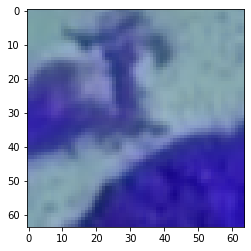

In [34]:
lon, lat = -71.9388,-9.1947
tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=1.5, tilesize=64, pad=0)
im = get_image(tile.key)
plt.imshow(im)
pass

### 7.2 Make FeatureCollection

We will store the results from our deployment in a `FeatureCollection` [ML: Add link] For an in-depth discussion of vector data, refer to the Vector tutorial [ML:add link]. 

In [36]:
name = 'coffee-classification-demo'
coffee_vectors = dl.vectors.FeatureCollection.create(
    product_id=name, 
    title='Classifying-Coffee', 
    description='Classifying coffee using deep learning'
)

In [37]:
pid = dl.Auth().namespace + ':' + name

The product ID will be passed to the deployment function and will allow us to upload data to this specific product with Tasks.

### 7.3 Make a Task Group

To finish preparing the `Task` create a function. that loads the model, fetches the imagery, processes the imagery, predicts results, and uploads the results to our `FeatureCollection`. Our prediction will be stored as a `label` property on each vector `Feature`.

In [40]:
def predict_coffee(dltile_key, vector_pid):
    import descarteslabs as dl
    from tensorflow.keras.applications.resnet50 import preprocess_input
    
    tile = dl.scenes.DLTile.from_key(dltile_key)
    model = load_model_from_storage('coffee_demo')
    
    im = get_image(dltile_key)
    im = preprocess_input(im)
    
    label_schema = {0: 'coffee', 1: 'noncoffee'}
    pred = model.predict(im[None,:])
    label = label_schema[int(pred[0] > 0.5)]
    
    result_fc = dl.vectors.FeatureCollection(vector_pid)
    result_fc.add(dl.vectors.Feature(tile, properties={'key': tile.key, 'label': label}))
    pass

Now we're ready to create a `Task` group.

In [ ]:
#[ML: you already declared this above, right? Can this be removed] 
# Python 3.6
docker_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.6/default:v2019.06.04-4-g4c7c582e'
# Python 3.7
# docker_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7/default:v2019.08.08-7-g062b0653'

In [41]:
async_predict = tasks.create_function(
    f=predict_coffee,
    name='coffee-demo-deploy',
    image=docker_image,
    maximum_concurrency=10
)

The task group is now ready to receive work.

### 7.4 Deploy

Let's say we wanted to deploy our model over a new region in Brazil. Like before, we can define an area of interest and divide that area into tiles. Those tiles are sent to Tasks one at a time to be executed in parallel.

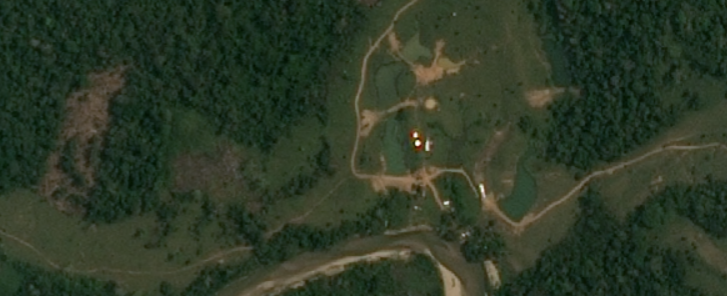

In [42]:
aoi = {"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-71.94141411768213,-9.199109466451048],[-71.93553471486666,-9.199109466451048],[-71.93553471486666,-9.193466616402858],[-71.94141411768213,-9.193466616402858],[-71.94141411768213,-9.199109466451048]]]}}

In [43]:
tiles = dl.scenes.DLTile.from_shape(aoi, tilesize=64, resolution=1.5, pad=0)

In [44]:
len(tiles)

64

In [45]:
for tile in tiles:
    async_predict(tile.key, pid)

As before we can monitor the status of our Task through the client or online. 

## 8. Results
_______________

As the Tasks are being completed, we can retreive the data as it arrives.

In [52]:
coffee_vectors.count()

6

Once we have the labels we can see what the predictions were.

In [53]:
coffee_labels = [feat.properties['label'] for feat in coffee_vectors.filter(geometry=aoi).features()]

In [54]:
coffee_labels.count('coffee'), coffee_labels.count('noncoffee')

(36, 28)

Most of the tiles are classified as coffee.

## 9. Wrap-Up
__________

In this tutorial, we have used a deep learning classifier to analyze raw data and stored its results. Starting with Tensorflow and Keras, we created a model that classifies the presence of coffee in aerial imagery, setup the generators for training, and trained our model. Finally, we deployed our model using `Tasks` across a small set of test points and stored the results. These steps are broadly applicable to many kinds of machine learning and computer vision applications. The Descartes Labs APIs and services used here allow model inference to scale by several orders of magnitude without having to provision or manage computing resources.

## Resources
______________________

[1] [Scenes Documentation](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html)

[2] [Tasks Documentation](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html)

[3] [Vectors Documentation](https://docs.descarteslabs.com/descarteslabs/vectors/readme.html)

[4] [Keras Documentation](https://keras.io/)

[5] [Brazilian Coffee Scenes](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/) and associated [paper](https://www.researchgate.net/publication/319404195_Performance_Enhancement_of_Satellite_Image_Classification_Using_a_Convolutional_Neural_Network)

[6] [ResNet50 Model Information](https://arxiv.org/abs/1512.03385)